In [7]:
import pandas as pd
import seaborn as sns
import sys
from matplotlib import pyplot as plt

%matplotlib inline

MIN_PYTHON = (3, 6)
if sys.version_info < MIN_PYTHON:
    sys.exit("Python %s.%s or later is required.\n" % MIN_PYTHON)

In [8]:
df1 = pd.read_csv('part1.log.csv', 
                  index_col='TS', 
                  names=['TS', 'Speed', 'TLD', 'Location'], 
                  parse_dates=True)

df2 = pd.read_csv('part2.log.csv', 
                  index_col='TS', 
                  names=['TS', 'Speed', 'TLD', 'Location'], 
                  parse_dates=True)

# remove data outside of our test date range
df1 = df1.loc['2017-11-20':'2017-11-22']
df2 = df2.loc['2017-11-20':'2017-11-22']

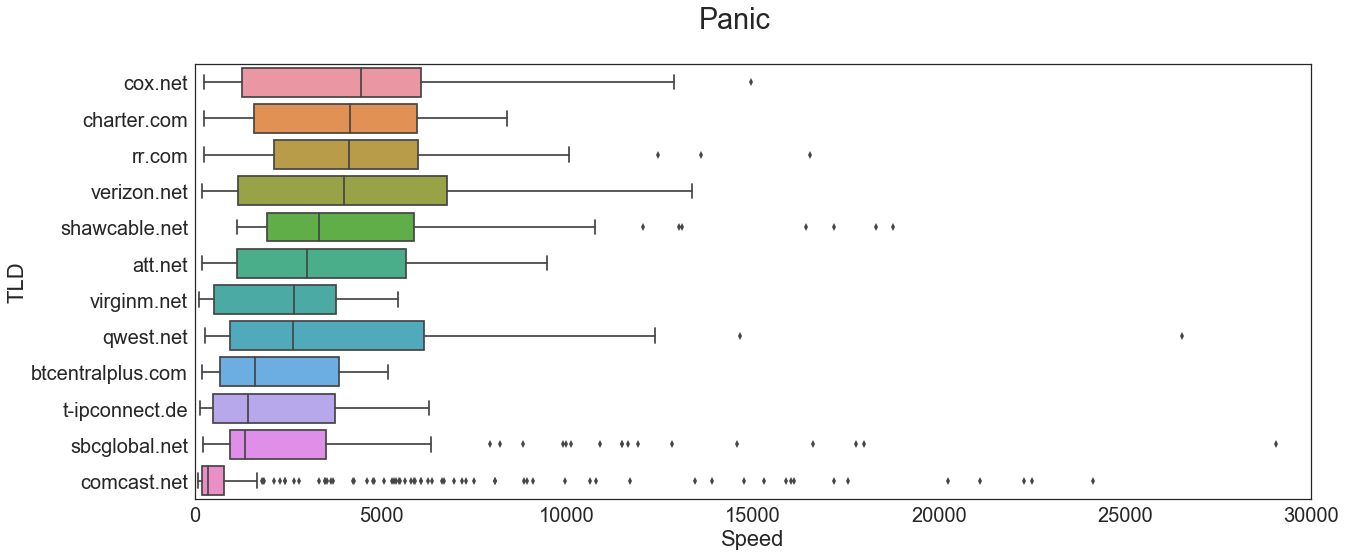

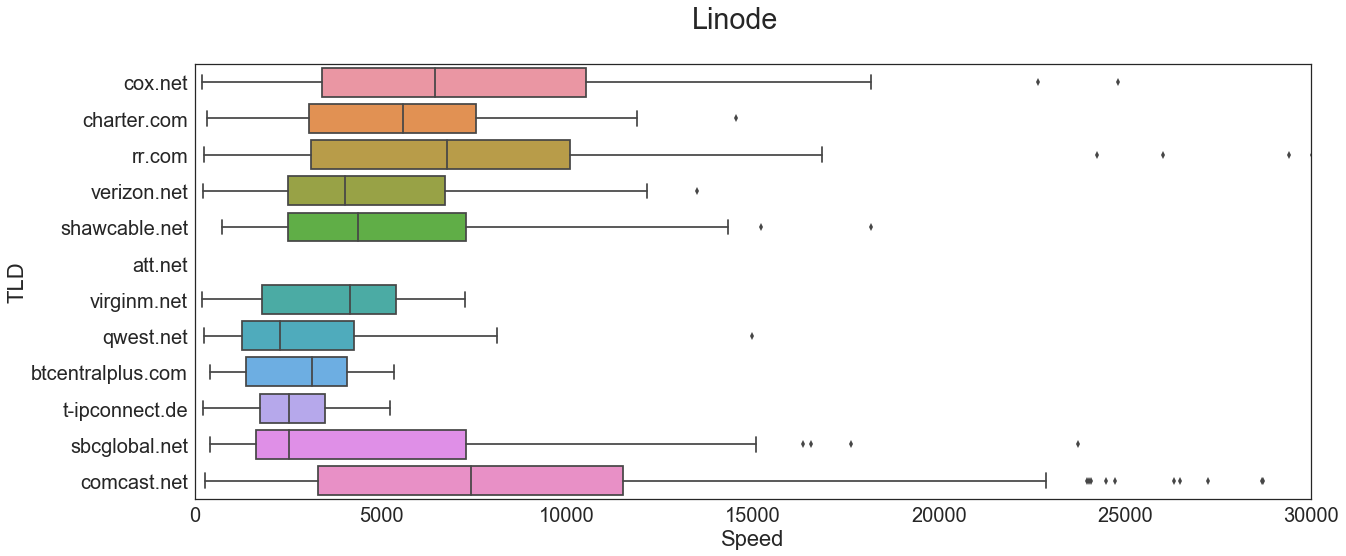

In [31]:
# remove rows from TLDs with low occurances
df1_c = df1[df1.groupby('TLD').Speed.transform(len) >= 30].copy(True)
df2_c = df2[df2.groupby('TLD').Speed.transform(len) >= 30].copy(True)

# print(df1_c['TLD'].value_counts())
# print(df2_c['TLD'].value_counts())

# Filter by speed
# df1_c = df1_c[df1_c['Speed'] < 15000]
# df2_c = df2_c[df2_c['Speed'] < 15000]

# Sort the TLDs by mean speed
ranks1 = df1_c.groupby("TLD")["Speed"].median().fillna(0).sort_values()[::-1].index
ranks2 = df2_c.groupby("TLD")["Speed"].median().fillna(0).sort_values()[::-1].index

FIG_WIDTH = 20
FIG_HEIGHT = 8
sns.set(font_scale=2)
sns.set_style("white")

fig, _ = plt.subplots()
fig.set_figwidth(FIG_WIDTH)
fig.set_figheight(FIG_HEIGHT)
fig.suptitle('Panic')
bp1 = sns.boxplot(data=df1_c, 
                  y='TLD', 
                  x='Speed', 
                  orient='h', 
                  order=ranks1)
_ = bp1.set(xlim=(0, 30000))

fig, _ = plt.subplots()
fig.set_figwidth(FIG_WIDTH)
fig.set_figheight(FIG_HEIGHT)
fig.suptitle('Linode')
bp2 = sns.boxplot(data=df2_c, 
                  y='TLD', 
                  x='Speed', 
                  orient='h', 
                  order=ranks1)
_ = bp2.set(xlim=(0, 30000))


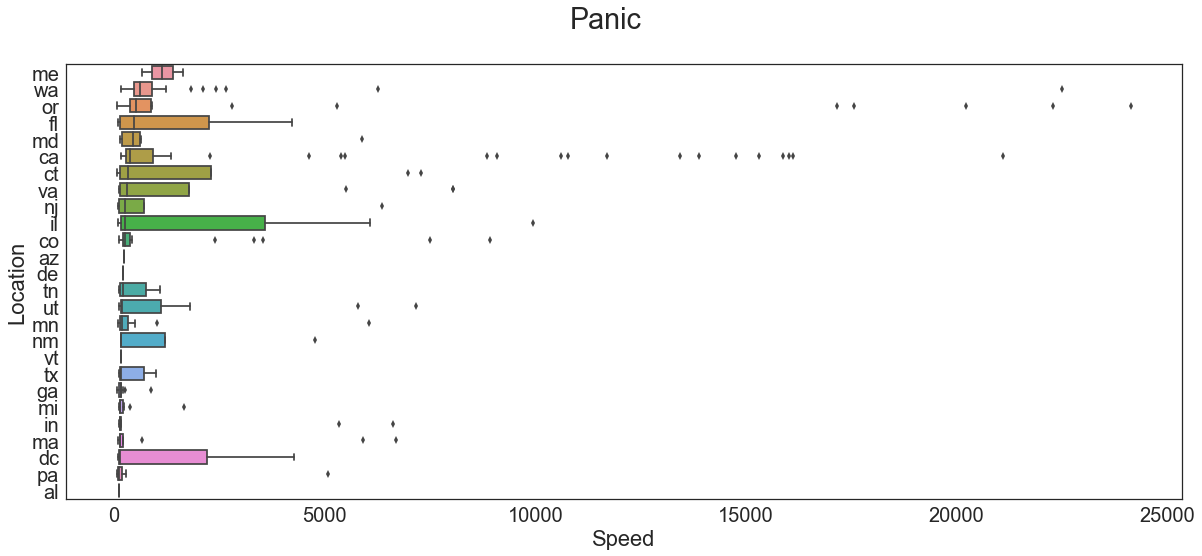

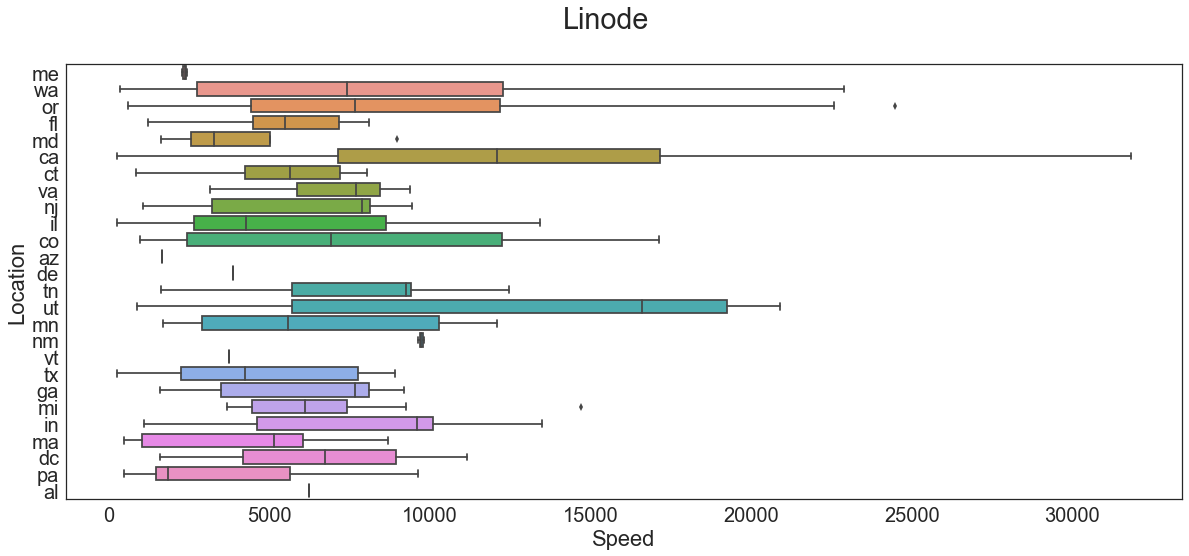

In [20]:
# Filter by speed
# df1 = df1[df1['Speed'] < 5000]
# df2 = df2[df2['Speed'] < 5000]

# Sort the states by mean speed
ranks1 = df1.groupby("Location")["Speed"].median().fillna(0).sort_values()[::-1].index
ranks2 = df2.groupby("Location")["Speed"].median().fillna(0).sort_values()[::-1].index

fig, _ = plt.subplots()
fig.set_figwidth(FIG_WIDTH)
fig.set_figheight(FIG_HEIGHT)
_ = fig.suptitle('Panic')
bp1 = sns.boxplot(data=df1, y='Location', x='Speed', orient='h', order=ranks1)

fig, _ = plt.subplots()
fig.set_figwidth(FIG_WIDTH)
fig.set_figheight(FIG_HEIGHT)
fig.suptitle('Linode')
bp2 = sns.boxplot(data=df2, y='Location', x='Speed', orient='h', order=ranks1)

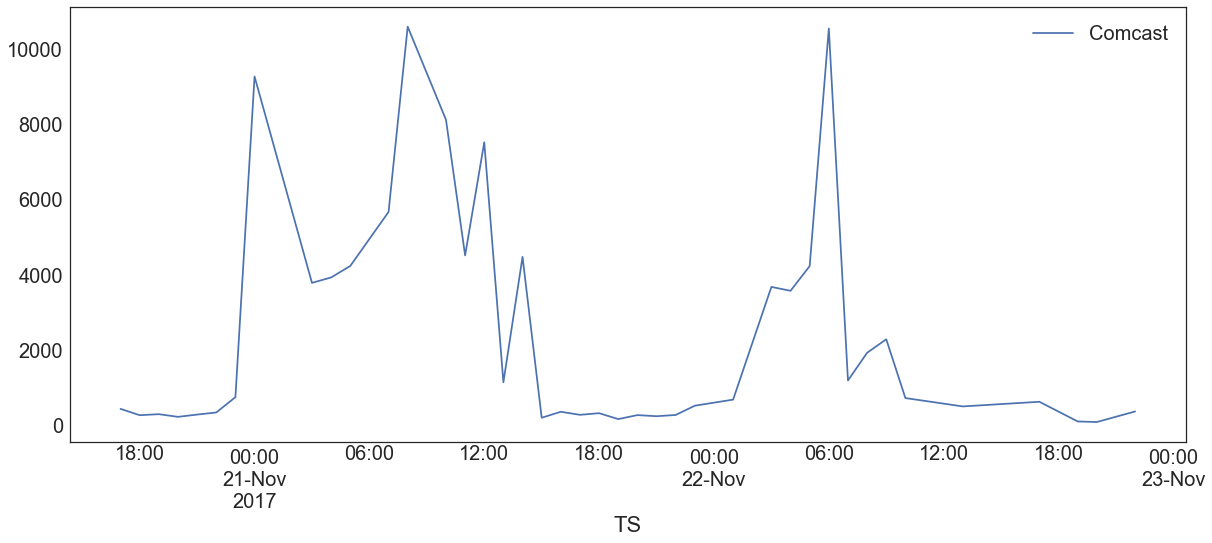

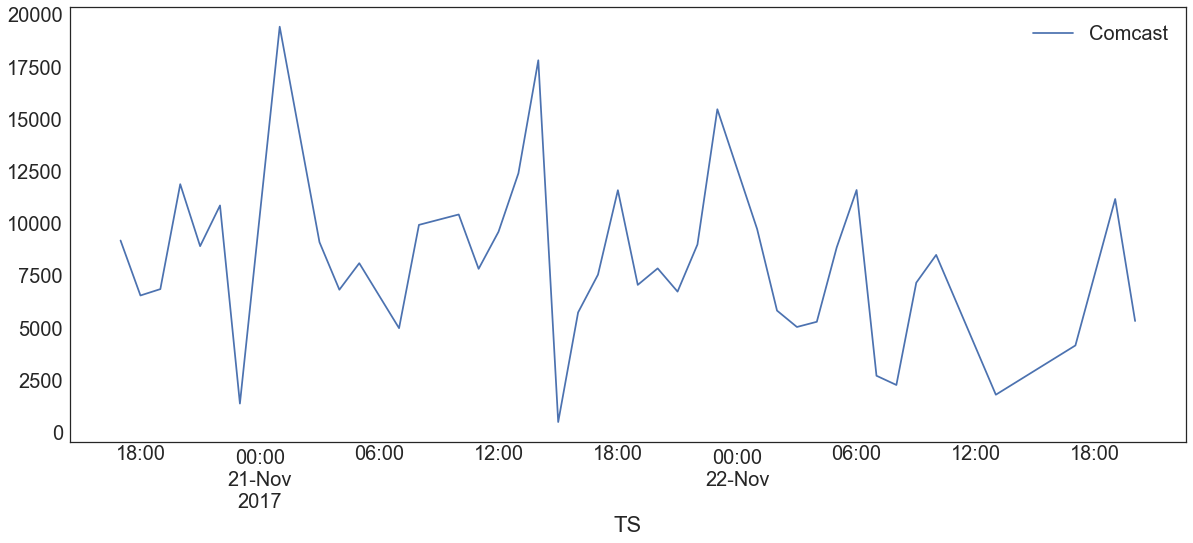

In [34]:
df1_c = df1.copy(True)
df2_c = df2.copy(True)

df1_cc = df1_c[df1_c['TLD'] == 'comcast.net'].resample('h').mean()
df1_rr = df1_c[df1_c['TLD'] == 'rr.com'].resample('h').mean()
df1_vz = df1_c[df1_c['TLD'] == 'verizon.net'].resample('h').mean()

df2_cc = df2_c[df2_c['TLD'] == 'comcast.net'].resample('h').mean()
df2_rr = df2_c[df2_c['TLD'] == 'rr.com'].resample('h').mean()
df2_vz = df2_c[df2_c['TLD'] == 'verizon.net'].resample('h').mean()

df1_cc['Speed'].interpolate(inplace=True)
df1_rr['Speed'].interpolate(inplace=True)
df1_vz['Speed'].interpolate(inplace=True)

df2_cc['Speed'].interpolate(inplace=True)
df2_rr['Speed'].interpolate(inplace=True)
df2_vz['Speed'].interpolate(inplace=True)

fig, _ = plt.subplots()
fig.set_figwidth(FIG_WIDTH)
fig.set_figheight(FIG_HEIGHT)
# fig.suptitle('comcast vs RR to Panic')

df1_cc['Speed'].plot(label="Comcast")
# df1_rr['Speed'].plot(label="Road Runner")
# df1_vz['Speed'].plot(label="Verizon")
_ = plt.legend()

fig, _ = plt.subplots()
fig.set_figwidth(FIG_WIDTH)
fig.set_figheight(FIG_HEIGHT)
# fig.suptitle('comcast vs RR to Linode')

df2_cc['Speed'].plot(label="Comcast")
# df2_rr['Speed'].plot(label="Road Runner")
# df2_vz['Speed'].plot(label="Verizon")
_ = plt.legend()


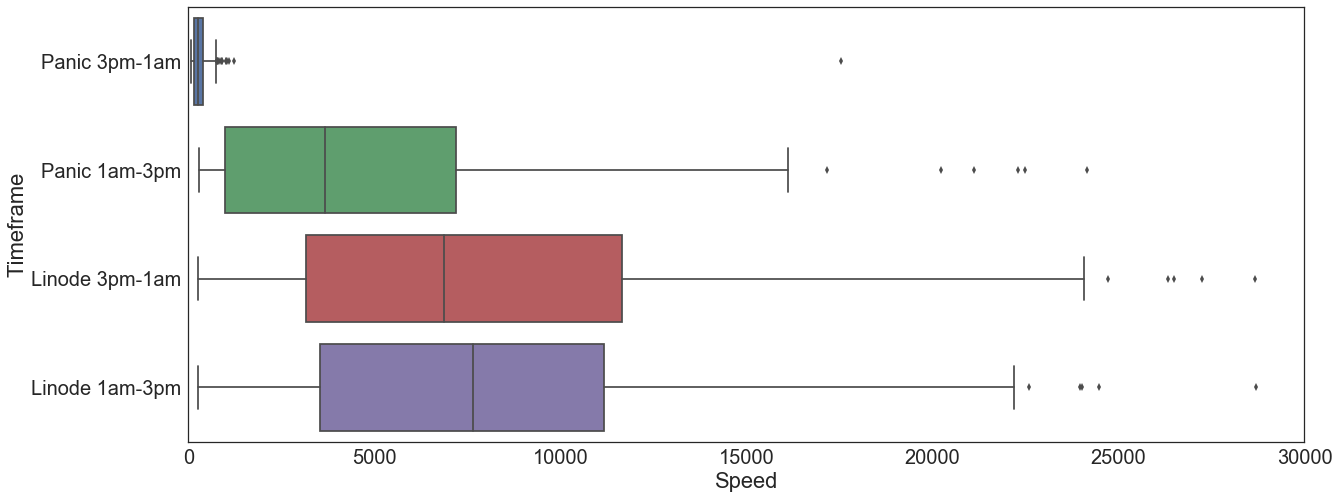

In [35]:
def get_dfs_filtered_by_time(df, label):
    hour = df.index.hour
    selector_l = ((15 <= hour) & (hour <= 23)) | ((0 <= hour) & (hour < 1))
    selector_h = ((1 <= hour) & (hour < 15))
    
    df_l = df[selector_l].assign(Timeframe=f'{label} 3pm-1am')
    df_h = df[selector_h].assign(Timeframe=f'{label} 1am-3pm')
    
    return df_l, df_h


def plot_by_tld(df1, df2, tld):
    df1 = df1[df1['TLD'] == tld]
    df2 = df2[df2['TLD'] == tld]

    df1_l, df1_h = get_dfs_filtered_by_time(df1, 'Panic')
    df2_l, df2_h = get_dfs_filtered_by_time(df2, 'Linode')
    df_combined = pd.concat([df1_l, df1_h, df2_l, df2_h])

    fig, _ = plt.subplots()
    fig.set_figwidth(FIG_WIDTH)
    fig.set_figheight(FIG_HEIGHT)
    bp = sns.boxplot(data=df_combined, y='Timeframe', x='Speed', orient='h')
    _ = bp.set(xlim=(0, 30000))

# filter into 2 buckets 3pm-1am and 1am-3pm


plot_by_tld(df1_c, df2_c, 'comcast.net')
# plot_by_tld(df1_c, df2_c, 'sbcglobal.net')
# plot_by_tld(df1_c, df2_c, 'rr.com')
# plot_by_tld(df1_c, df2_c, 'verizon.net')
# plot_by_tld(df1_c, df2_c, 'comcastbusiness.net')
